In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.activations import relu, elu, linear, softmax
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.losses import mean_squared_error, categorical_crossentropy, logcosh, MeanSquaredLogarithmicError
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
import time

In [419]:
ls = [float("NaN"),5]
from statistics import stdev

stdev(np.nan_to_num(ls))


3.5355339059327378

In [74]:
# import data
data1 = pd.read_csv("Combined_Data1.csv")
data2 = pd.read_csv("Combined_Data2.csv")

X1 = data1.iloc[:,3:]
X2 = data2.iloc[:,7:]

y_list1 = [data1.iloc[:,1],data1.iloc[:,2]]

y_list2 = []
for i in range(6):
    y_list2.append(data2.iloc[:,i+1])

[0      2.516485
1      1.640909
2      0.416348
3      1.338558
4      1.729517
         ...   
259    1.646250
260    0.734435
261    2.749310
262    1.102444
263    0.873561
Name: ss_yld, Length: 264, dtype: float64, 0      3.023356
1      5.938064
2      3.977654
3      3.708053
4      4.183696
         ...   
259    3.115603
260    3.276900
261    5.125369
262    4.146705
263    2.149131
Name: ww_yld, Length: 264, dtype: float64]


In [211]:
# Simplified Data Preprocessing
def data_preprocess(dataset,target):
    X = pd.DataFrame(dataset)
    
    Y = pd.DataFrame(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X,Y)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    scaler.fit(y_train)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)
    
    return X_train, X_test, y_train, y_test

In [217]:
def data_preprocess(dataset,target): 
    # Scaled data
    min_max_scaler = MinMaxScaler(feature_range = (0,1))
    np_scaled = min_max_scaler.fit_transform(dataset)
    X = pd.DataFrame(np_scaled)
    
    target_edit = pd.Series(target).values
    target_edit = target_edit.reshape(-1,1)
    np_scaled = min_max_scaler.fit_transform(target_edit)
    Y = pd.DataFrame(np_scaled)
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
      
    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
        
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_preprocess(X2,y_list2[0])

In [44]:
# create cnn model to call for grid search
def baseline_model(nSNP):
    def create_conv_NN():
        nStride=3  # stride between convolutions
        nFilter=64 # filters
        model_cnn = Sequential()
    
        # add convolutional layer with l1 and l2 regularization
        model_cnn.add(Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1), kernel_regularizer='l1_l2'))
        model_cnn.add(Conv1D(nFilter, kernel_size=3, activation='relu'))
        # dropout added for regularization
        model_cnn.add(Dropout(0.2))
        # add pooling layer: takes maximum of two consecutive values
        model_cnn.add(MaxPooling1D(pool_size=2))
        # Solutions above are linearized to accommodate a standard layer
        model_cnn.add(Flatten())
        model_cnn.add(Dense(64))
        # activation layer
        # model_cnn.add(Activation('relu'))
        # model_cnn.add(Dense(32))
        model_cnn.add(Activation('linear'))
        model_cnn.add(Dense(1)) 
        
        # Model Compiling
        model_cnn.compile(loss='logcosh', optimizer='Adam')
        return model_cnn
    return create_conv_NN

In [272]:
def data_preprocess(dataset,target): 
    min_max_scaler = MinMaxScaler(feature_range = (0,1))
    np_scaled = min_max_scaler.fit_transform(dataset)
    X = pd.DataFrame(np_scaled)
    
    target_edit = pd.Series(target).values
    target_edit = target_edit.reshape(-1,1)
    np_scaled = min_max_scaler.fit_transform(target_edit)
    Y = pd.DataFrame(np_scaled)
    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
    
    scaler = StandardScaler()
    # Fit only to the training data
    scaler.fit(X_train)
        
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    return X_train, X_test, y_train, y_test

def cal_correlation(pred, y_test, target):
    pred = pred.reshape((-1,1))
    target_edit = pd.Series(target).values
    target_edit = target_edit.reshape(-1,1)
    min_max_scaler = MinMaxScaler(feature_range = (0,1))
    np_scaled = min_max_scaler.fit_transform(target_edit)
    target_pred = min_max_scaler.inverse_transform(pred)
    target_orig = min_max_scaler.inverse_transform(y_test)
    target_orig = target_orig[:,0]
    target_orig = pd.Series(target_orig)
    target_pred = target_pred[:,0]
    target_pred = pd.Series(target_pred)
    cor1 = target_orig.corr(target_pred, method='pearson')
    return cor1

fontsize1 = 13
fontsize2 = 16

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss',fontsize=fontsize2)
    plt.ylabel('loss',fontsize=fontsize1)
    plt.xlabel('epoch',fontsize=fontsize1)
    plt.ylim(0,1)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_cv_loss(results):
    plt.plot(results)
    plt.title('model loss',fontsize=fontsize2)
    plt.ylabel('loss',fontsize=fontsize1)
    plt.xlabel('epoch',fontsize=fontsize1)
    plt.ylim(0,1)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def prediction_plot(test,pred,title):
    plt.title(('Observed vs Predicted value for', title))
    plt.ylabel('Predicted', fontsize=fontsize1)
    plt.xlabel('Observed', fontsize=fontsize1)
    plt.scatter(y_test, pred, marker='o')
    plt.show()

(227, 1) (57, 1)


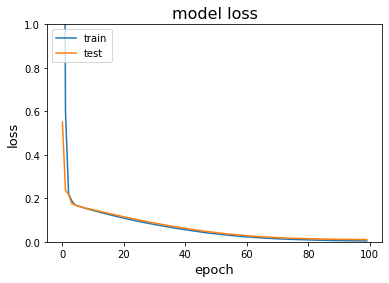

Score: -0.008736911229789257 Corr: 0.5120859802631904


(-0.008736911229789257,
 0.5120859802631904,
 array([0.5703095 , 0.38779807, 0.43668947, 0.5000875 , 0.478122  ,
        0.570385  , 0.41012788, 0.5260518 , 0.6292117 , 0.3091614 ,
        0.5704428 , 0.57417357, 0.41821265, 0.4507046 , 0.32941294,
        0.5227211 , 0.58804685, 0.53767234, 0.49492773, 0.5361588 ,
        0.5471764 , 0.51663846, 0.5214774 , 0.5413939 , 0.7327543 ,
        0.49878427, 0.38158053, 0.5307581 , 0.53173345, 0.562195  ,
        0.49508905, 0.4579913 , 0.4014923 , 0.38016194, 0.4001878 ,
        0.4063986 , 0.5345295 , 0.42508167, 0.49820292, 0.5535899 ,
        0.2327207 , 0.6153232 , 0.34177768, 0.5378399 , 0.5317773 ,
        0.38974956, 0.48974186, 0.5094375 , 0.5415011 , 0.57256955,
        0.5083421 , 0.5256943 , 0.64258146, 0.53921705, 0.57748264,
        0.5409974 , 0.52680874], dtype=float32))

In [273]:
# single run of cnn
target = y_list2[0]
X_train, X_test, y_train, y_test = data_preprocess(X2,target)
print(y_train.shape,y_test.shape)
cnn(X_train, X_test, y_train, y_test)
#best_params, score, pred = cnn(X_train, X_test, y_train, y_test)
#print(best_params)

(211, 1135) (53, 1135) (211, 1) (53, 1)


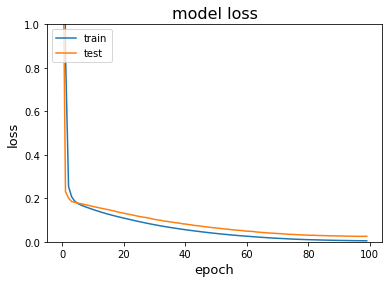

Score: -0.0300771351903677 Corr: -0.004830970099145042
-0.0300771351903677 -0.004830970099145042


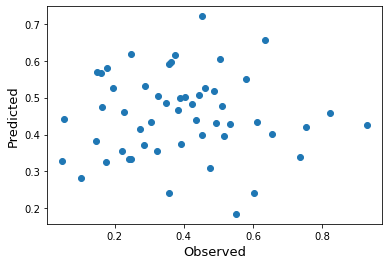

In [399]:
# Build CNN Model
def baseline_model(nSNP):
    def create_conv_NN():
        nStride=3  # stride between convolutions
        nFilter=64 # filters
        model_cnn = Sequential()

        # add convolutional layer with l1 and l2 regularization
        model_cnn.add(Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1), kernel_regularizer='l1_l2'))
        model_cnn.add(Conv1D(nFilter, kernel_size=3, activation='relu'))
        # dropout added for regularization
        model_cnn.add(Dropout(x))
        # add pooling layer: takes maximum of two consecutive values
        model_cnn.add(MaxPooling1D(pool_size=2))
        # Solutions above are linearized to accommodate a standard layer
        model_cnn.add(Flatten())
        model_cnn.add(Dense(64))
        # activation layer
        model_cnn.add(Activation('linear'))
        model_cnn.add(Dense(1))

        # Model Compiling
        opt = Adam(learning_rate=0.001)
        model_cnn.compile(loss='logcosh', optimizer=opt)
        return model_cnn
    return create_conv_NN

# Train and evaluateCNN without grid search
def cnn(X_train, X_test, y_train, y_test):
    # need this to match dimensions
    X2_train = np.expand_dims(X_train, axis=2) 
    X2_test = np.expand_dims(X_test, axis=2) 
    
    nSNP=X_train.shape[1] 
    early_stopping = EarlyStopping(patience = 5)
    
    #build cnn regressor
    cnn = KerasRegressor(build_fn=baseline_model(nSNP), verbose=0)
    result = cnn.fit(X2_train, y_train, validation_split=0.2,callbacks=[early_stopping], epochs = 100, batch_size=16)
    #result = cnn.fit(X2_train, y_train, validation_split=0.2, epochs = 100, batch_size=16)
    plot_loss(result)
    pred = cnn.predict(X2_test)
    score = (cnn.score(X2_test,y_test))
    corr = cal_correlation(pred, y_test, target)
    print("Score:",score,"Corr:",(corr))
    score = (cnn.score(X2_test,y_test))
    
    return score, corr, pred

def cnn_grid(X_train, X_test, y_train, y_test):
    # Need this to match dimensions
    X2_train = np.expand_dims(X_train, axis=2) 
    X2_test = np.expand_dims(X_test, axis=2) 
    
    nSNP=X_train.shape[1] 
    #early_stopping = EarlyStopping(patience = 5)
    early_stopping = EarlyStopping()
    #build cnn regressor
    cnn = KerasRegressor(build_fn=baseline_model(nSNP), verbose=0)
    #hyper parameters
    batch_size = [16,32]
    epochs = [100]
    
    #parameter space
    param_grid = dict(epochs=epochs, batch_size=batch_size)
    # Grid search with 5 fold cross validation
    grid = GridSearchCV(estimator=cnn, param_grid=param_grid, cv=2)
    #fit training data
    grid_result = grid.fit(X2_train, y_train, validation_split=0.2, callbacks=[early_stopping])
    #get best model
    best_params = grid_result.best_params_
    print("best parameters: ", best_params)
    
    # predict for test set  
    pred = grid.predict(X2_test)
    score = (grid.score(X2_test,y_test))
    corr = cal_correlation(pred, y_test, target)
    
    return score, corr, best_params

X_train, X_test, y_train, y_test = data_preprocess(X1,y_list1[0])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
#score, corr, params = cnn_grid(X_train, X_test, y_train, y_test)
#print(score, corr, params)

score, corr, pred = cnn(X_train, X_test, y_train, y_test)
print(score,corr)
prediction_plot(y_test,pred,'name')

In [236]:
print(score)
print(corr)
print(params)

-0.012403246946632862
0.33549509289463153
{'batch_size': 16, 'epochs': 150}


ww_flm


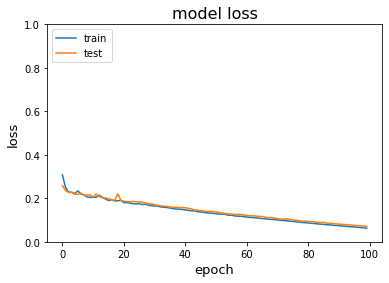

Score: -0.07140839844942093 Corr: 0.16721193519761615


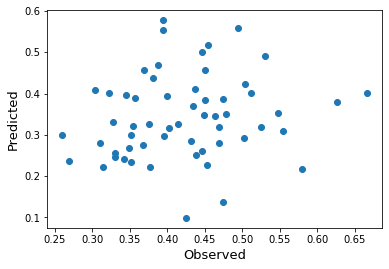

-0.07140839844942093


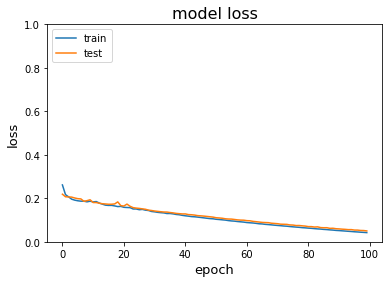

Score: -0.04962253198027611 Corr: 0.2798693227360822


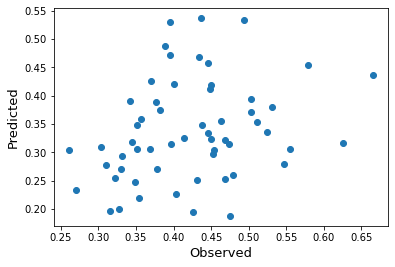

-0.04962253198027611


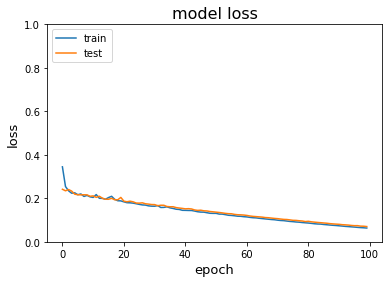

Score: -0.06948187202215195 Corr: 0.28415952197973804


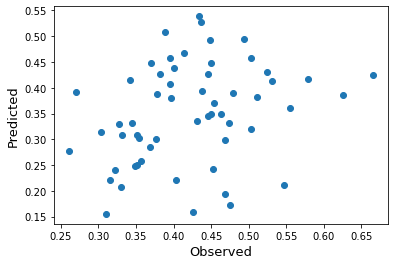

-0.06948187202215195


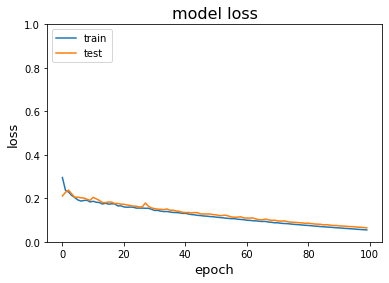

Score: -0.06280166655778885 Corr: 0.26464924847556687


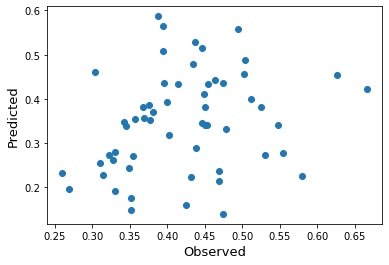

-0.06280166655778885


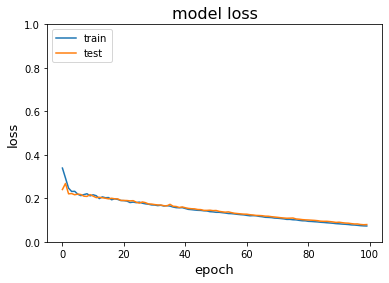

Score: -0.08029966056346893 Corr: 0.2769145683717733


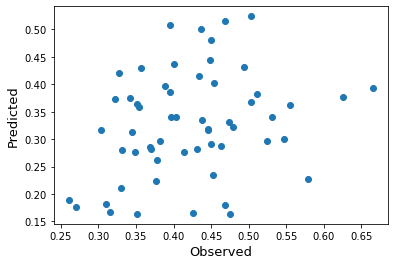

-0.08029966056346893
ww_flm


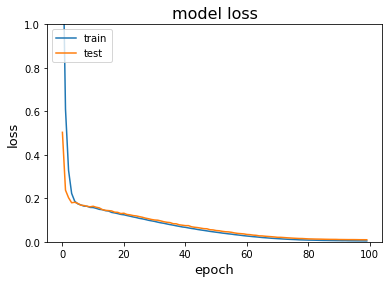

Score: -0.007175887003540993 Corr: 0.37403234336591057


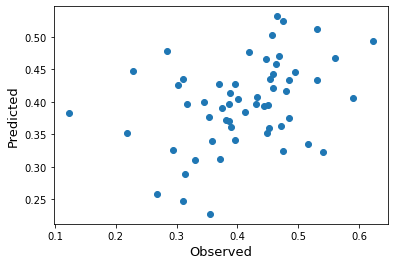

-0.007175887003540993


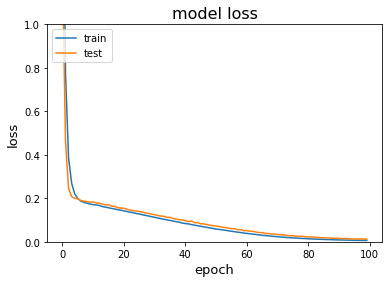

Score: -0.008813418447971344 Corr: 0.46450108691192665


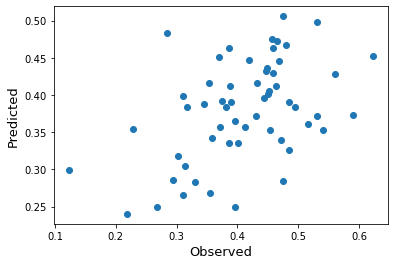

-0.008813418447971344


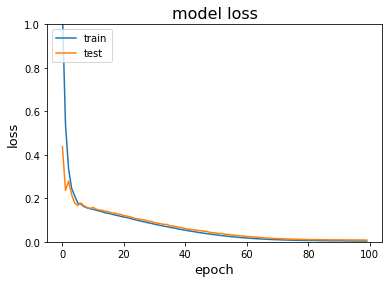

Score: -0.006416843738406897 Corr: 0.4154203805615878


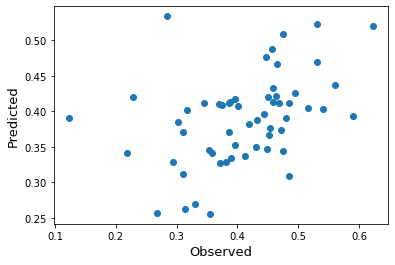

-0.006416843738406897


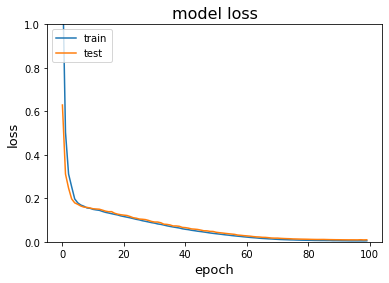

Score: -0.006887683644890785 Corr: 0.3879850213872901


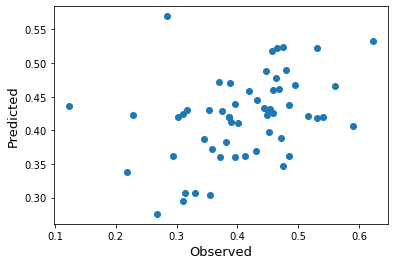

-0.006887683644890785


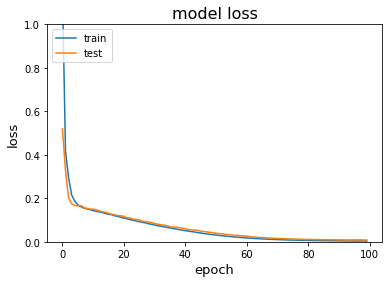

Score: -0.006600718945264816 Corr: 0.4058134688960445


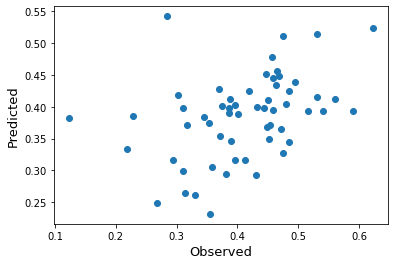

-0.006600718945264816
ww_flm


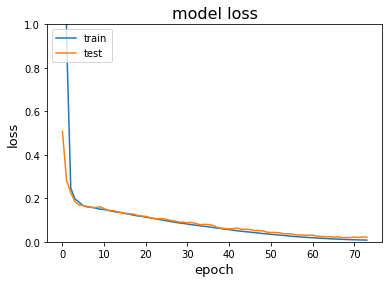

Score: -0.021652234718203545 Corr: 0.19310831983612128


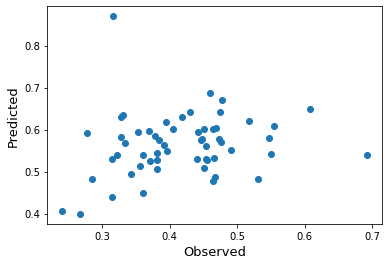

-0.021652234718203545


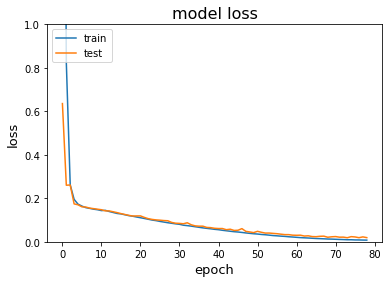

Score: -0.020852888002991676 Corr: 0.2356808907463063


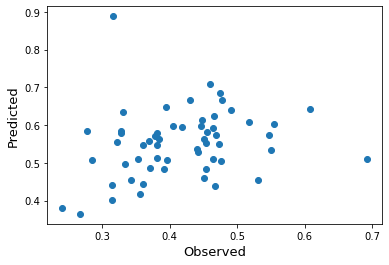

-0.020852888002991676


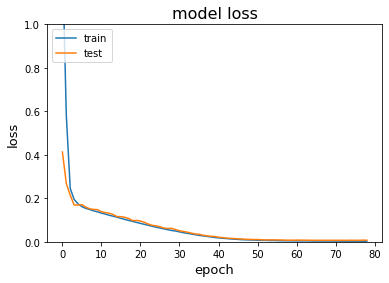

Score: -0.006889649201184511 Corr: 0.268117811117526


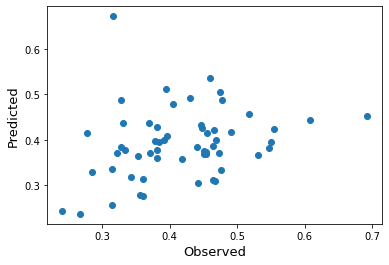

-0.006889649201184511


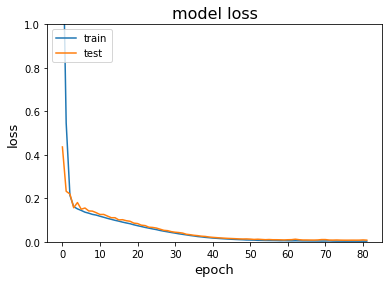

Score: -0.007413064129650593 Corr: 0.19781808752520144


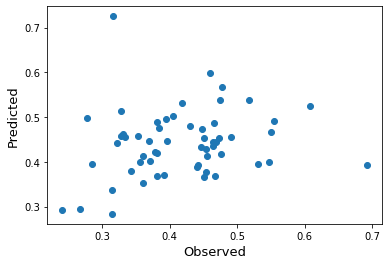

-0.007413064129650593


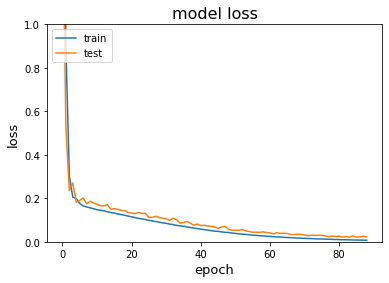

Score: -0.022961704060435295 Corr: 0.2291280404188666


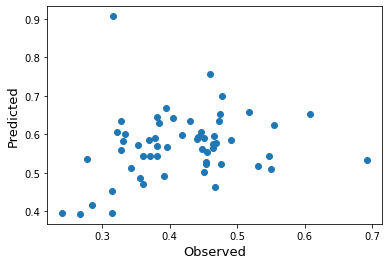

-0.022961704060435295
ww_flm


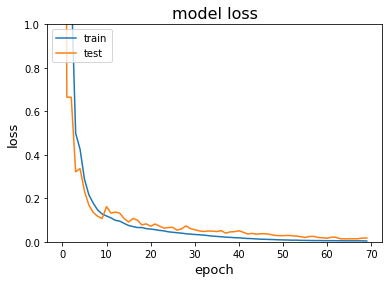

Score: -0.016994375735521317 Corr: 0.2222915815921095


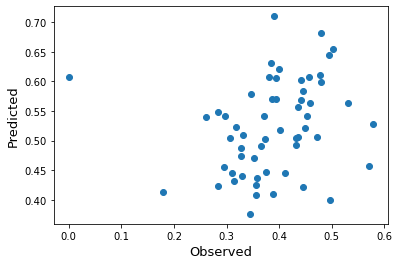

-0.016994375735521317


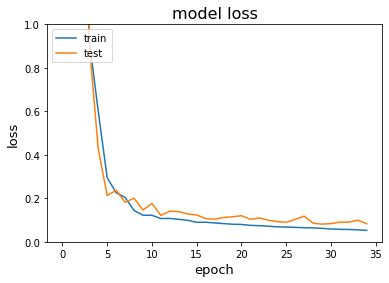

Score: -0.08952237665653229 Corr: 0.06495074906466924


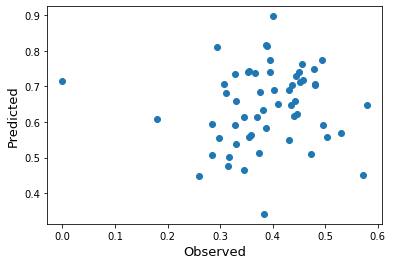

-0.08952237665653229


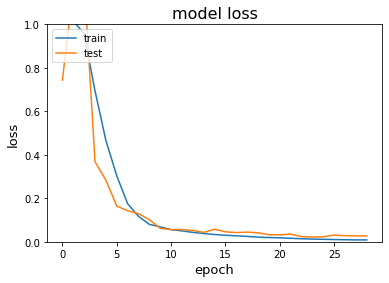

Score: -0.031852468848228455 Corr: 0.1488143785804187


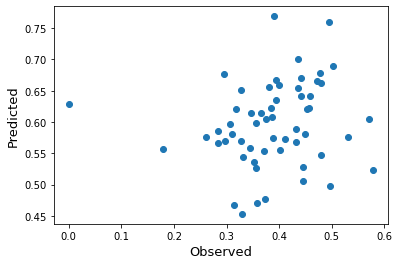

-0.031852468848228455


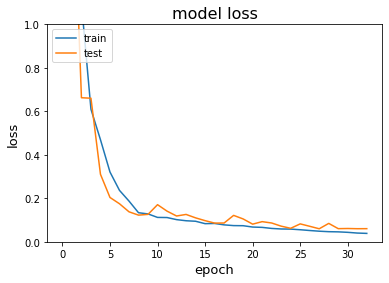

Score: -0.06731721013784409 Corr: 0.03084969494123901


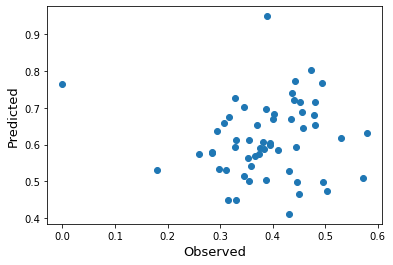

-0.06731721013784409


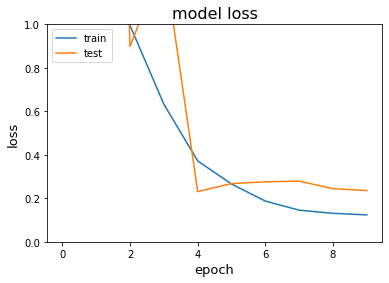

Score: -0.26888522505760193 Corr: -0.07269251296474899


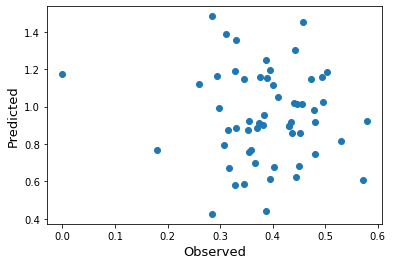

-0.26888522505760193


In [400]:
# Data visualisation with all traits - no cross validation
data_list = []
for y in y_list1:
    data_list.append((X1,y))
for y in y_list2:
    data_list.append((X2,y))

all_results = []
trait_list = []
#dropout_list = [0,0.1,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.98]
#dropout_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
rate_list = [0.0001,0.0005,0.001,0.005]
param_list = []

for x in rate_list:
    # Build CNN Model
    def baseline_model(nSNP):
        def create_conv_NN():
            nStride=3  # stride between convolutions
            nFilter=64 # filters
            model_cnn = Sequential()

            # add convolutional layer with l1 and l2 regularization
            model_cnn.add(Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1), kernel_regularizer='l1_l2'))
            model_cnn.add(Conv1D(nFilter, kernel_size=3, activation='linear'))
            # dropout added for regularization
            model_cnn.add(Dropout(0.3))
            # add pooling layer: takes maximum of two consecutive values
            model_cnn.add(MaxPooling1D(pool_size=2))
            # Solutions above are linearized to accommodate a standard layer
            model_cnn.add(Flatten())
            model_cnn.add(Dense(64))
            # activation layer
            model_cnn.add(Activation('linear'))
            model_cnn.add(Dense(1))

            # Model Compiling
            opt = Adam(learning_rate=x)
            model_cnn.compile(loss='logcosh', optimizer=opt)
            return model_cnn
        return create_conv_NN
    corr_list = []
    # Run for each trait
    for (X,y) in [data_list[7]]:
        print(y.name)
        X_train, X_test, y_train, y_test = data_preprocess(X,y)
        # run repetitions for each trait
        for i in range(5):
            score,corr,pred = cnn(X_train, X_test, y_train, y_test)
            trait_list.append(y.name)
            corr_list.append(corr)
            prediction_plot(y_test,pred,y.name)
            print(score)
    all_results.append(corr_list)

In [354]:
do_not_edit = all_results

In [370]:
print(all_results)

[[0.023929324175283852, -0.1538503146316675], [0.2641643806260763, 0.20619790208822053], [0.11317346430016334, 0.1632772568923147], [0.27962578788017445, 0.3298501118947207], [nan, nan], [nan, nan]]


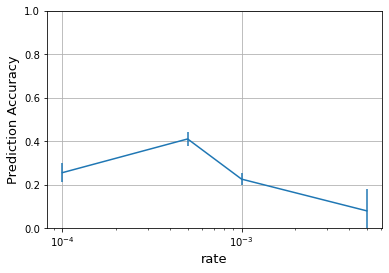

In [401]:
all_results

means = []
stds = []
for list in all_results:
    means.append(np.mean(list))
    stds.append(np.std(list))

plt.errorbar(x=rate_list, y=means, yerr=stds)
plt.ylabel('Prediction Accuracy', fontsize=13)
plt.xlabel('rate', fontsize=13)
plt.ylim(0,1)
#plt.xlim(0,1)
plt.xscale('log')
plt.grid()
plt.show()

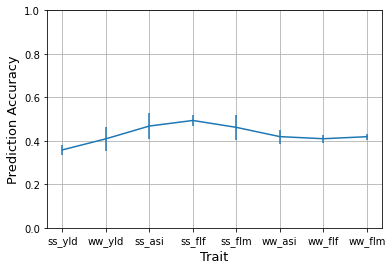

In [347]:
results = all_results[0]
means = []
stds = []
for i in range(8):
    means.append(np.mean(results[i:i+3]))
    stds.append(np.std(results[i:i+3]))

x = []
for i in range(8):
    x.append(trait_list[i*3])

plt.errorbar(x=x, y=means, yerr=stds)
plt.ylabel('Prediction Accuracy', fontsize=13)
plt.xlabel('Trait', fontsize=13)
plt.ylim(0,1)

plt.grid()
plt.show()

In [307]:



results_df = pd.DataFrame(all_results)
#results_df.insert(0, "learning_rate",rate_list, True)
results_df.head()
#results_df.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.181339,0.127456,0.141941,0.192091,0.192325,0.033909,0.129987,0.260185,0.215518,0.330245,...,0.002908,0.017021,0.058465,0.005414,0.144522,0.08365,0.045099,0.008722,0.095896,0.092945


In [123]:
all_results.append(corr_list)
print(all_results)
# 1: dropout = 0.5, n_filter = 64
# 2: dropout = 0.2, n_filter = 64
# 3: dropout = 0.8, n_filter = 64
# 4: dropout = 0.2, n_filter = 32
# 5: dropout = 0.8, n_filter = 32

[(1, [('ss_yld', 0.2995275675417049), ('ww_yld', 0.4801077899431653), ('ss_asi', 0.5686103420096553), ('ss_flf', 0.5425278034458842), ('ss_flm', 0.17137659038062966), ('ww_asi', 0.38591608061506827), ('ww_flf', 0.26148658526531166), ('ww_flm', 0.37940592348162766)]), (1, [('ss_yld', 0.24380052296814106), ('ww_yld', 0.4149039176197508), ('ss_asi', 0.45443056761748984), ('ss_flf', 0.3150686350223723), ('ss_flm', 0.3196444556088304), ('ww_asi', 0.4944167011666647), ('ww_flf', 0.30152504573993905), ('ww_flm', 0.3905385009669849)]), (1, [('ss_yld', 0.3206672905809988), ('ww_yld', 0.6313092297398109), ('ss_asi', 0.5779769335363127), ('ss_flf', 0.5244641146638485), ('ss_flm', 0.37891832023293814), ('ww_asi', 0.3779994010789768), ('ww_flf', 0.2555498299122983), ('ww_flm', 0.1635824520248126)]), (1, [('ss_yld', 0.22397018848392225), ('ww_yld', 0.47926852312198376), ('ss_asi', 0.49663865918204975), ('ss_flf', 0.5026916750999045), ('ss_flm', 0.2542730970394322), ('ww_asi', 0.3464591491018914), ('

In [184]:
results_df.to_csv('CNN_Data4')

In [ ]:
# #CNN with grid search
def cnn(X_train, X_test, y_train, y_test):
    # need this to match dimensions
    X2_train = np.expand_dims(X_train, axis=2) 
    X2_test = np.expand_dims(X_test, axis=2) 
    
    nSNP=X_train.shape[1] 
    early_stopping = EarlyStopping()
    
    #build cnn regressor
    cnn = KerasRegressor(build_fn=baseline_model(nSNP), verbose=0)
    #hyper parameters
    batch_size = [16,32,64]
    epochs = [100,150]
    param_grid = dict(epochs=epochs, batch_size=batch_size)
    grid = GridSearchCV(estimator=cnn, param_grid=param_grid, cv=5, n_jobs=10)
    grid_result = grid.fit(X2_train, y_train, validation_split=0.2, callbacks=[early_stopping])
    best_params = grid_result.best_params_
    print("best parameters: ", best_params)
    
    pred = grid.predict(X2_test)
    score = (grid.score(X2_test,y_test))
    print("Score:",score,"Corr:",(cal_correlation(pred, y_test, target)))
    print(y_test.shape)
    print(pred.shape)
    plt.title('MLP: Observed vs Predicted Y')
    plt.ylabel('Predicted')
    plt.xlabel('Observed')
    plt.scatter(y_test, pred, marker='o')
    plt.show()
    score = (grid.score(X2_test,y_test))
    
    return best_params, score, pred

best parameters:  {'batch_size': 16, 'epochs': 100}
Score: -0.021913908421993256 Corr: 0.499715755960332
(57, 1)
(57,)


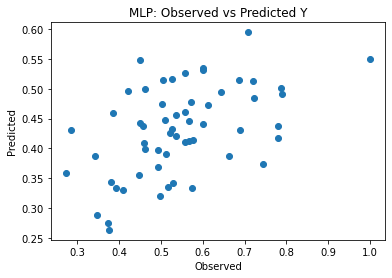

best parameters:  {'batch_size': 16, 'epochs': 100}
Score: -0.017568686977028847 Corr: 0.4892250933623448
(57, 1)
(57,)


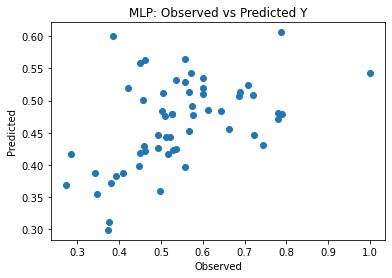

best parameters:  {'batch_size': 16, 'epochs': 100}
Score: -0.021136220544576645 Corr: 0.4092505019967125
(57, 1)
(57,)


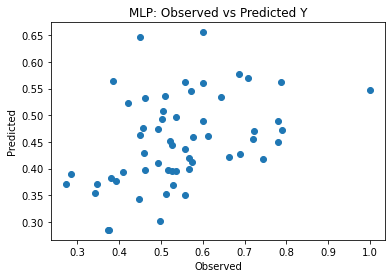

best parameters:  {'batch_size': 16, 'epochs': 150}
Score: -0.017621370032429695 Corr: 0.5550352866723065
(57, 1)
(57,)


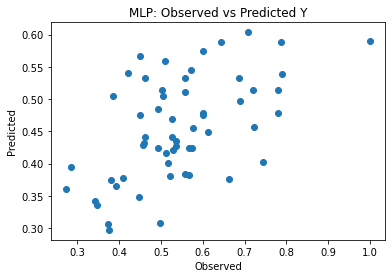

best parameters:  {'batch_size': 16, 'epochs': 150}
Score: -0.02485831454396248 Corr: 0.4618777350699162
(57, 1)
(57,)


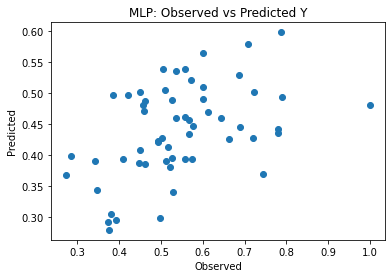

best parameters:  {'batch_size': 16, 'epochs': 100}
Score: -0.3174718916416168 Corr: 0.025372861186570773
(57, 1)
(57,)


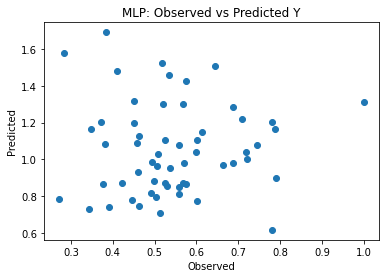

In [61]:
target = y_list2[0]
X_train, X_test, y_train, y_test = data_preprocess(X2,target)
f_values = [16,32,64]
d_values = [0.1,0.2,0.5,0.8]
p_values = [2,3,4]

av_scores = []
all_scores = []
for x in [0.1,0.2,0.5]:
    scores = []
    for i in range(2):
        def baseline_model(nSNP):
            def create_conv_NN():
                nStride=3  # stride between convolutions
                nFilter=64 # filters
                model_cnn = Sequential()

                # add convolutional layer with l1 and l2 regularization
                model_cnn.add(Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1), kernel_regularizer='l1_l2'))
                model_cnn.add(Conv1D(nFilter, kernel_size=3, activation='relu'))
                # dropout added for regularization
                model_cnn.add(Dropout(x))
                # add pooling layer: takes maximum of two consecutive values
                model_cnn.add(MaxPooling1D(pool_size=2))
                # Solutions above are linearized to accommodate a standard layer
                model_cnn.add(Flatten())
                model_cnn.add(Dense(64))
                # activation layer
                #model_cnn.add(Activation('relu'))
                #model_cnn.add(Dense(32))
                model_cnn.add(Activation('linear'))
                model_cnn.add(Dense(1)) 

                # Model Compiling
                model_cnn.compile(loss='logcosh', optimizer='Adam')
                return model_cnn
            return create_conv_NN
        best_params, score, pred = cnn(X_train, X_test, y_train, y_test)
        scores.append(score)
        all_scores.append(score)
    av_scores.append((x,np.mean(scores)))

In [168]:
from statistics import stdev
i = 0
inc = 5
for score in av_scores:
    std = stdev(all_scores[i:i+5])
    print(("%0.3f (+/-%0.03f) for %r" % (score[1], std * 2,score[0])))
    i += 1

-0.470 (+/-0.048) for 0.1
-0.489 (+/-0.046) for 0.2
-0.489 (+/-0.065) for 0.5
-0.514 (+/-0.066) for 0.8


In [ ]:
cor_cnn = []
acc_cnn = []

def main(X,y):
    X_train, X_test, y_train, y_test = data_preprocess(X,y)
    params,score,pred = cnn(X_train, X_test, y_train, y_test)
    corr = (np.corrcoef(y_test,pred))[0,1]
    print('Correlation for CNN ',corr)
    cor_cnn.append(cor_c)
    acc_cnn.append(scores_mlp)

#main(X2,y_list2[0])